In [1]:
import alignment, speech, applause_list, file_loader, text_features,re
import json, os, pickle, numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from IPython.display import Audio
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn import linear_model
import matplotlib.pyplot as plt
from tqdm import tqdm
%matplotlib inline

In [2]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Convolution2D, Conv1D, MaxPooling2D, MaxPooling1D, Flatten, Dropout
import keras.optimizers
from keras.models import load_model
import keras.regularizers
from keras.regularizers import l2, l1

from keras.layers import LSTM
from keras.layers import regularizers
from keras.layers import Bidirectional

Using TensorFlow backend.


In [24]:
def initialize_model():
    model = Sequential()
    model.add(Dense(600, use_bias=True,input_dim=305))#1924
    model.add(keras.layers.BatchNormalization())
    #model.add(Dropout(0.5))
    #model.add(Activation("relu"))
    model.add(Dense(50, use_bias=True))
    #model.add(keras.layers.BatchNormalization())
    #model.add(Dropout(0.5))
    model.add(Activation("relu"))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    optimizer = keras.optimizers.Adam()
    model.compile(optimizer=optimizer,loss='mean_absolute_error',metrics=['mean_absolute_error'])
    return model  

In [131]:
def initialize_lstm_model():
    model = Sequential()
    model.add(Dropout(0.3,input_shape=(5,305)))
    #model.add(Conv1D(6,3,padding='same',input_shape=(5, 305)))
    #model.add(keras.layers.BatchNormalization())
    #model.add(Activation('relu'))
    #model.add(MaxPooling1D(pool_size=3))
    #model.add(Conv1D(12,3,padding='same'))
    #model.add(keras.layers.BatchNormalization())
    #model.add(Activation('relu'))
    #model.add(MaxPooling1D(pool_size=3))
    #model.add(Flatten())
    #model.add(Dense(50))
    #model.add(Dropout(0.8))
    model.add(LSTM(200,input_shape=(None,305),return_sequences=False,dropout=0.0))
    #model.add(Bidirectional(LSTM(30, return_sequences=False, dropout=0.0),input_shape=(None, 305)))
    #model.add(Dropout(0.5))
    #model.add(Activation("relu"))
    #model.add(LSTM(50,return_sequences=False))
    #model.add(Dropout(0.5))
    #model.add(Activation("relu"))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    optimizer = keras.optimizers.Adam()
    model.compile(optimizer=optimizer,loss='mean_squared_error',metrics=['mean_absolute_error'])
    return model

In [47]:
def format_lstm_input(sequence_list,lstm_length=5):
    formatted_list = []
    for i in tqdm(range(lstm_length,len(sequence_list))):
        if len(formatted_list) == 0:
            formatted_list = [sequence_list[i-lstm_length:i].reshape((1,lstm_length,305))]
        else:
            formatted_list.append(sequence_list[i-lstm_length:i].reshape((1,lstm_length,305)))
    return np.vstack(formatted_list)

In [132]:
lstm_model = initialize_lstm_model()

In [107]:
time_series_lstm_model = initialize_lstm_model()

In [63]:
X_input = format_lstm_input(X_train)
y_input = y_train[5:]

test_X_input = format_lstm_input(X_test)
test_y_input = y_test[5:]

100%|██████████| 177165/177165 [00:00<00:00, 768172.38it/s]


In [64]:
X_input.shape

(693356, 5, 305)

In [65]:
len(y_input)

693356

In [110]:
time_series_lstm_model.fit(X_input[:,:,300:],np.array(y_input),batch_size=512,epochs=1)
time_series_lstm_model.evaluate(test_X_input[:,:,300:],np.array(test_y_input),batch_size=512)

Epoch 1/1
177165/177165 [==============================] - 1s     


[0.13296976335753785, 0.13296976369128216]

In [133]:
lstm_model.fit(X_input,np.array(y_input),batch_size=512,epochs=1)
lstm_model.evaluate(test_X_input,np.array(test_y_input),batch_size=512)

Epoch 1/1
175616/177165 [============================>.] - ETA: 0s

[0.053737277529520358, 0.18031053088868876]

In [91]:
weights = [layer.get_weights() for layer in time_series_lstm_model.layers]
weights[1]

In [284]:
test_X = np.zeros((5000,305))
test_y = np.zeros(5000)

In [ ]:
np.array(format_lstm_input(test_X)).shape

In [6]:
def get_preds_and_sents(s,start_index, end_index):
    sents = [s.alignment.get_preceding_chars(i) for i in range(start_index,end_index)]
    p = preds[start_index:end_index]
    return zip(sents, p)

In [7]:
all_files = file_loader.get_non_duplicate_file_endings()

In [8]:
speeches = []
for f in tqdm(all_files):
    speeches.append(speech.Speech(f))

100%|██████████| 354/354 [02:09<00:00,  5.64it/s]


In [10]:
train_speeches, test_speeches = train_test_split(speeches,test_size=0.2, random_state=43)

In [20]:
X = []
y = []
for s in tqdm(train_speeches):
    preds = s.applause_preds_by_second
    for i in range(5,len(preds)):
        raw_text = s.alignment.get_preceding_chars(i)
        if raw_text != '':
            tf = text_features.TextFeatures(raw_text)
            vec = tf.get_mean_vector(tf.sentences)
            lag = preds[i-5:i]
            vec = np.hstack([vec,lag])
            X.append(vec)
            y.append(preds[i])
X_train = X; y_train = y

100%|██████████| 283/283 [41:20<00:00,  7.68s/it]


In [21]:
X = []
y = []
for s in tqdm(test_speeches):
    preds = s.applause_preds_by_second
    for i in range(5,len(preds)):
        raw_text = s.alignment.get_preceding_chars(i)
        if raw_text != '':
            tf = text_features.TextFeatures(raw_text)
            vec = tf.get_mean_vector(tf.sentences)
            lag = preds[i-5:i]
            vec = np.hstack([vec,lag])
            X.append(vec)
            y.append(preds[i])
X_test = X; y_test = y

100%|██████████| 71/71 [10:25<00:00,  8.83s/it]


In [22]:
#with open('/data/corpora/cspan/x_train.pkl','r') as f:
#    X_train = pickle.load(f)

In [23]:
#with open('/data/corpora/cspan/x_test.pkl','r') as f:
#    X_test = pickle.load(f)

In [221]:
model = initialize_model()

In [224]:
model.fit(X_train,np.array(y_train),shuffle=True, batch_size=128, epochs=1,verbose=True)

Epoch 1/1
693361/693361 [==============================] - 30s - loss: 0.2274 - mean_absolute_error: 0.2274    


In [225]:
model.evaluate(X_test[:,0:300],np.array(y_test),batch_size=128)

176000/177170 [============================>.] - ETA: 0s

[0.23995049270861857, 0.23995049255251677]

In [218]:
np.mean(np.abs(model.predict(X_test,batch_size=256).reshape(np.array(y_test).shape)-np.array(y_test)))

0.099726789

ValueError: cannot reshape array of size 1830 into shape (1,5,305)

In [248]:
5*305

1525

In [156]:
X_train=np.array(X_train)
X_test = np.array(X_test)

In [ ]:
np.array(X_train)[:,-5:].shape

In [166]:
clf=linear_model.Ridge(alpha=0)
clf.fit(X_train,y_train)
linreg_preds = clf.predict(X_test)
error = mean_absolute_error(linreg_preds, y_test)
print "error: %s\n" % error
print "Coefficients: " + str(clf.coef_[-5:])

error: 0.112042740888

Coefficients: [ 0.00239686 -0.01917981  0.011392   -0.01185767  0.85748204]


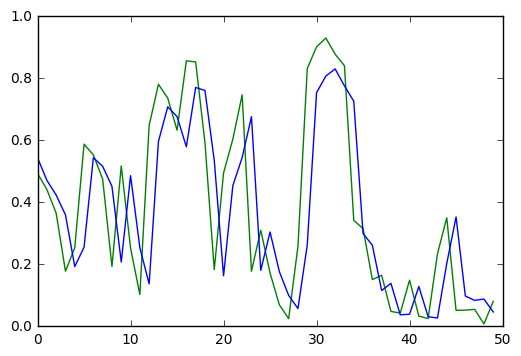

In [404]:
start = 500
end = start+50
plt.plot(y_test[start:end], color='green')
plt.plot(linreg_preds[start:end], color = 'blue')
plt.show()

In [428]:
lstm_model_preds = lstm_model.predict(test_X_input)
time_series_lstm_preds = time_series_lstm_model.predict(test_X_input[:,:,300:])

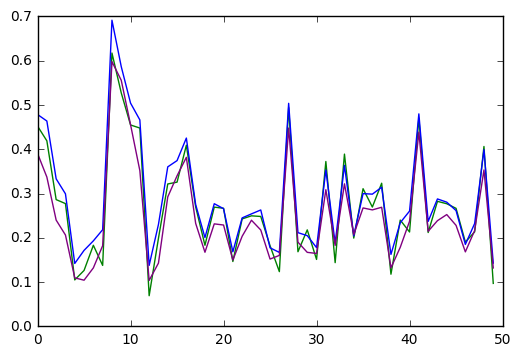

In [433]:
start = 1700
end = start + 50
plt.plot(test_y_input[start:end], color='green')
plt.plot(lstm_model_preds[start:end], color = 'blue')
plt.plot(time_series_lstm_preds[start:end], color = 'purple')
plt.show()

In [30]:


raw_text = s.alignment.get_preceding_chars(79)
raw_text

u"and three months ago it was my high honor to accept my party's nomination to run and in just one day to have the opportunity to serve as the next vice president of the United States the was. And I want to thank my friend Congressman Frank into. I want"

In [48]:
tf = text_features.TextFeatures(raw_text)
tf.sentences

[u"and  three  months  ago  it  was  my  high  honor  to  accept  my  party 's  nomination  to  run  and  in  just  one  day  to  have  the  opportunity  to  serve  as  the  next  vice  president  of  the  United  States  the  was . ",
 u'And  I  want  to  thank  my  friend  Congressman  Frank  into . ',
 u'I  want']

In [20]:
import numpy as np, re, spacy
nlp = spacy.load('en')

In [59]:
np.mean(np.array([nlp(sent).vector for sent in tf.sentences]),axis=0)

(300,)

In [51]:
n.vector

array([  2.50853989e-02,   5.58765382e-02,  -1.10743772e-02,
        -1.68480892e-02,   6.12825491e-02,  -4.88266870e-02,
        -4.16259728e-02,   1.35906762e-03,   2.14037057e-02,
         1.32676375e+00,  -1.01865567e-01,  -2.14839145e-03,
         4.68341112e-02,  -2.86373850e-02,  -6.80278987e-02,
        -4.84908484e-02,  -5.66921234e-02,   5.16139030e-01,
        -8.59587267e-02,   1.77103654e-02,  -3.41125811e-03,
        -4.55646515e-02,  -3.39471437e-02,  -7.64499838e-03,
        -1.80700012e-02,   2.78469529e-02,  -7.56080151e-02,
        -1.82580911e-02,  -2.37098988e-02,   3.11631877e-02,
         3.14707011e-02,   8.14324692e-02,  -3.12258909e-03,
         4.61970791e-02,   2.44393237e-02,  -4.40632664e-02,
        -1.97279043e-02,  -1.84566416e-02,  -3.52335051e-02,
        -3.21370810e-02,   3.31807323e-03,   5.58771640e-02,
         9.82258562e-03,  -7.07367212e-02,   4.12488393e-02,
         1.87425260e-02,  -6.01787120e-02,   6.94476301e-03,
         1.95381884e-03,

In [135]:
st = ' '.join(s.alignment.get_preceding_aligned_words(1800))

In [136]:
tf = text_features.TextFeatures(st)
tf.sentences

[u"it 's  great  to  be  back  here  i  remind  you  one  of  the  things  said  four  years  ago  was n't  that  big  of  an  issue  four  years  ago  commander  in  chief  is  not  an  entry  level  position  you  have  a  lot  of  wonderful  people  on  this  stage  but  very  few  of  them  very  few  them  have  the  experience"]